# Project ML & DM : Loan Strübi & Aurélie Wasem

## Import

In [70]:
from typing import Dict, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import kagglehub

import os

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.inspection import permutation_importance

from scipy.stats import chi2_contingency

import networkx as nx
from matplotlib.lines import Line2D

## Global functions

In [71]:
def evaluate_income_classifiers(
    df: pd.DataFrame,
    *,
    income_col: str = "income",
    positive_label: str = ">50K",
    test_size: float = 0.2,
    random_state: int = 42,
    cv: int = 5,
    n_bootstrap: int = 20,
    models: Optional[Dict[str, BaseEstimator]] = None,
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    """
    Evaluate multiple classification models for predicting high income (>50K) from a dataset.

    This function:
      1) Builds X from all columns except `income_col`
      2) Builds y as binary (<=50K -> 0, >50K -> 1)
      3) One-hot encodes categorical features with pd.get_dummies(drop_first=True)
      4) Splits into train/test with stratification
      5) Trains each model and reports:
         - Test Accuracy
         - Test F1-score
         - ROC-AUC (using predict_proba or decision_function when available)
         - Cross-validated Accuracy (on full dataset)
         - Bootstrap CI for Accuracy (computed on bootstrap resamples of the train set)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing features and an income label column.
    income_col : str
        Name of the target column in `df`.
    positive_label : str
        Label considered as the positive class (mapped to 1). All other labels -> 0.
    test_size : float
        Fraction of the dataset reserved for the test split.
    random_state : int
        Random seed for reproducibility (split + bootstrap).
    cv : int
        Number of folds for cross-validation accuracy.
    n_bootstrap : int
        Number of bootstrap resamples for the train accuracy confidence interval.
    models : dict[str, BaseEstimator] | None
        Optional custom model dictionary. If None, a default set is used.

    Returns
    -------
    results_df : pd.DataFrame
        Table of model performances.
    artifacts : dict
        Useful artifacts for downstream analysis:
          - "X": full one-hot encoded feature matrix
          - "y": binary target
          - "X_train", "X_test", "y_train", "y_test": split data
          - "models": the model dictionary used
    """
    if income_col not in df.columns:
        raise ValueError(f"'{income_col}' column not found in df. Available columns: {list(df.columns)}")

    # ---------- Define X and y properly (classification) ----------
    X = df.drop(columns=[income_col])

    y_raw = df[income_col]
    y = (y_raw.astype(str).str.strip() == positive_label).astype(int)

    # One-hot encode categorical features
    X = pd.get_dummies(X, drop_first=True, dtype=float)

    # Train / test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )

    # ---------- Bootstrap on ACCURACY ----------
    def bootstrap_accuracy(
        model: BaseEstimator,
        X_arr: np.ndarray,
        y_arr: np.ndarray,
        *,
        n_bootstrap: int = 20,
        random_state: int = 42,
    ) -> np.ndarray:
        """
        Estimate accuracy confidence interval via bootstrap (training-resample accuracy).

        Notes
        -----
        This reproduces your original logic: we bootstrap-resample the *train set*,
        fit the model, and compute accuracy on that same resample. This tends to be
        optimistic (training accuracy). If you want a stricter CI, use OOB bootstrap
        (train on resample, evaluate on out-of-bag samples).

        Returns percentiles [2.5, 97.5].
        """
        rng = np.random.RandomState(random_state)
        metrics = []

        n = len(X_arr)
        for _ in range(n_bootstrap):
            idx = rng.choice(n, n, replace=True)
            X_sample = X_arr[idx]
            y_sample = y_arr[idx]

            model.fit(X_sample, y_sample)
            y_pred = model.predict(X_sample)
            metrics.append(accuracy_score(y_sample, y_pred))

        return np.percentile(metrics, [2.5, 97.5])

    # ---------- Classification models only ----------
    if models is None:
        models = {
            "KNN": KNeighborsClassifier(
                n_neighbors=5,
                weights="uniform",
                metric="minkowski",
            ),
            "Linear SVM": LinearSVC(
                C=1.0,
                random_state=random_state,
            ),
            "Naive Bayes": GaussianNB(),
            "Random Forest": RandomForestClassifier(
                n_estimators=200,
                random_state=random_state,
                n_jobs=-1,
            ),
            "Decision Tree": DecisionTreeClassifier(
                max_depth=None,
                random_state=random_state,
            ),
            "Gradient Boosting": GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                random_state=random_state,
            ),
            "AdaBoost": AdaBoostClassifier(
                n_estimators=100,
                learning_rate=0.1,
                random_state=random_state,
            ),
        }

    # ---------- Evaluation loop ----------
    results = []

    for name, model in models.items():
        # Fit on train
        model.fit(X_train, y_train)

        # Predictions on test set
        y_pred = model.predict(X_test)

        # Accuracy & F1
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # ROC AUC (if we have a score/proba)
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_score)
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
            auc = roc_auc_score(y_test, y_score)
        else:
            auc = np.nan

        # Cross-validation accuracy on the full dataset
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
        cv_mean = cv_scores.mean()

        # Bootstrap CI on accuracy (train set)
        ci = bootstrap_accuracy(
            model,
            X_train.values,
            y_train.values,
            n_bootstrap=n_bootstrap,
            random_state=random_state,
        )

        results.append(
            {
                "Model": name,
                "Test_Accuracy": np.round(acc, 3),
                "Test_F1": np.round(f1, 3),
                "ROC_AUC": np.round(auc, 3) if not np.isnan(auc) else np.nan,
                "CV_Accuracy": np.round(cv_mean, 3),
                "Acc_CI_2.5": np.round(ci[0], 3),
                "Acc_CI_97.5": np.round(ci[1], 3),
            }
        )

    results_df = pd.DataFrame(results)

    artifacts = {
        "X": X,
        "y": y,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "models": models,
    }

    return results_df, artifacts


def gradient_boosting_feature_importance_report(
    df: pd.DataFrame,
    *,
    target_col: str = "income",
    test_size: float = 0.3,
    random_state: int = 42,
    n_estimators: int = 100,
    learning_rate: float = 0.1,
    n_repeats: int = 10,
    scoring: str = "accuracy",
    drop_first: bool = True,
    dtype=float,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, object]]:
    """
    Train a Gradient Boosting classifier and compute feature importances in 3 forms:

    1) Impurity-based importance at dummy-level
       - Uses model.feature_importances_ for each one-hot encoded feature.

    2) Impurity-based importance aggregated by original variable
       - Groups dummies by prefix before the first underscore.
         Example: 'workclass_Private' -> 'workclass'
                  'age' -> 'age'

    3) Permutation importance aggregated by original variable
       - Permutes each dummy-level column in X_test, measures the mean drop in the chosen
         scoring metric, then aggregates by original variable.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe that contains features + target.
    target_col : str
        Name of the target column.
    test_size : float
        Fraction of data used for the held-out test split.
    random_state : int
        Seed for reproducibility (train/test split, model, permutation importance).
    n_estimators : int
        Number of boosting stages.
    learning_rate : float
        Learning rate shrinks the contribution of each tree.
    n_repeats : int
        Number of permutation repeats for permutation importance.
    scoring : str
        Scoring metric used for permutation importance (e.g., "accuracy", "f1", "roc_auc").
    drop_first : bool
        Whether to drop the first dummy to avoid multicollinearity in one-hot encoding.
    dtype : type
        dtype used by pd.get_dummies (default: float).

    Returns
    -------
    impurity_dummy_df : pd.DataFrame
        Dummy-level impurity importances sorted desc (columns: Feature, Importance).
    impurity_by_var_df : pd.DataFrame
        Aggregated impurity importances by original variable (columns: Variable, Importance).
    perm_by_var_df : pd.DataFrame
        Aggregated permutation importances by original variable (columns: Variable, Perm_Importance).
    artifacts : dict
        Extra useful objects:
          - "model": fitted GradientBoostingClassifier
          - "X", "y": full encoded design matrix + target
          - "X_train", "X_test", "y_train", "y_test": the split data
          - "feat_imp": pd.Series of dummy-level impurity importances
          - "perm_series": pd.Series of dummy-level permutation importances (means)
    """
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' not found in df. Available columns: {list(df.columns)}")

    # -------- Features / target --------
    # X = all features except target, one-hot encoded
    X = pd.get_dummies(df.drop(columns=[target_col]), drop_first=drop_first, dtype=dtype)

    # y = raw target (keep as-is; can be strings like '<=50K' / '>50K' or already numeric)
    y = df[target_col]

    # Stratified split keeps the same class proportions in train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )

    # -------- Model: Gradient Boosting --------
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=random_state,
    )
    model.fit(X_train, y_train)

    # -------- Impurity-based importance (dummy-level) --------
    # model.feature_importances_ corresponds to X's column order (model.feature_names_in_)
    feat_imp = pd.Series(model.feature_importances_, index=model.feature_names_in_)

    impurity_dummy_df = (
        feat_imp
        .reset_index()
        .rename(columns={"index": "Feature", 0: "Importance"})
        .sort_values(by="Importance", ascending=False)
        .reset_index(drop=True)
    )

    # -------- Helper: map dummy -> original variable --------
    def original_var_name(col: str) -> str:
        """
        Extract original variable name from a dummy feature name.

        Examples
        --------
        - 'workclass_Private' -> 'workclass'
        - 'education-num'     -> 'education-num' (no underscore)
        - 'native-country_Italy' -> 'native-country'
        """
        return col.split("_")[0]

    # -------- Impurity-based importance aggregated by original variable --------
    impurity_by_var_df = (
        feat_imp
        .groupby(original_var_name)  # group all dummies with same prefix
        .sum()
        .sort_values(ascending=False)
        .rename_axis("Variable")
        .reset_index(name="Importance")
    )

    # -------- Permutation importance (dummy-level) --------
    # Permutation importance is model-agnostic: it measures how much performance drops
    # when a feature column is randomly permuted (breaking its link with the target).
    perm = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
    )

    # Mean performance drop for each dummy-level feature
    perm_series = pd.Series(perm.importances_mean, index=X.columns)

    # Aggregate drops by original variable (sum of drops across its dummies)
    perm_by_var_df = (
        perm_series
        .groupby(original_var_name)
        .sum()
        .sort_values(ascending=False)
        .rename_axis("Variable")
        .reset_index(name="Perm_Importance")
    )

    artifacts: Dict[str, object] = {
        "model": model,
        "X": X,
        "y": y,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "feat_imp": feat_imp,
        "perm_series": perm_series,
        "permutation_raw": perm,
    }

    return impurity_dummy_df, impurity_by_var_df, perm_by_var_df, artifacts


## Simulation

### Generation

In [72]:
# ---------- Global constants ----------
RNG = np.random.default_rng(2025)

# Categorical levels
WORKCLASS = ["Private","Self-emp-not-inc","Self-emp-inc","Federal-gov","Local-gov","State-gov","Without-pay","Never-worked"]
OCCUP = ["Tech-support","Craft-repair","Other-service","Sales","Exec-managerial","Prof-specialty",
         "Handlers-cleaners","Machine-op-inspct","Adm-clerical","Farming-fishing","Transport-moving",
         "Priv-house-serv","Protective-serv","Armed-Forces"]
MARITAL = ["Never-married","Married-civ-spouse","Divorced","Separated","Widowed","Married-spouse-absent","Married-AF-spouse"]
RACES = ["White","Black","Asian-Pac-Islander","Latin","Other"]
SEXES = ["Male","Female"]
COUNTRIES = ["Switzerland","Germany","France","Italy"
             ,"Austria","Portugal","Spain","Kosovo","North Macedonia"
             ,"Turkiye","Ukraine","Africa","The Americas","Asia"
             ,"Oceania","Stateless, nationality unknown"]

# Priors (probabilities) calibrated for CH 
p_workclass = np.array([0.732,0.100,0.051,0.020,0.042,0.050,0.003,0.002])
p_workclass/=p_workclass.sum()

p_occ = np.array([0.08,0.08,0.08,0.13,0.13,0.16,0.05,0.06,0.11,0.02,0.05,0.01,0.03,0.01])
p_occ/=p_occ.sum()

p_marital = np.array([0.462,0.398,0.090,0.003,0.045,0.001,0.001])
p_marital/=p_marital.sum()

p_sex = np.array([0.52,0.48])

p_race = np.array([0.6889,0.06,0.09,0.161,0.0001])
p_race/=p_race.sum()

# Countries: CH ~73%, others fill ~27% (weights approximated, renormalized)
p_country = np.array([0.73, 0.27*0.133,0.27*0.07,0.27*0.138
                      ,0.27*0.02,0.27*0.103,0.27*0.04,0.27*0.046,0.27*0.028
                      ,0.27*0.031,0.27*0.027,0.27*0.051,0.27*0.036,0.27*0.084
                      ,0.27*0.002,0.27*0.001,])
p_country[-1] = max(1e-9, 1.0 - p_country[:-1].sum())
p_country/=p_country.sum()

# ---------- Utilities ----------
def _softmax_rows(logits: np.ndarray) -> np.ndarray:
    """
    Row-wise softmax for a 2D logits matrix.

    Parameters
    ----------
    logits : np.ndarray, shape (n, k)
        Unnormalized log-probabilities per row.

    Returns
    -------
    np.ndarray, shape (n, k)
        Row-wise probability distributions.
    """
    z = logits - np.max(logits, axis=1, keepdims=True)
    p = np.exp(z)
    p /= p.sum(axis=1, keepdims=True)
    return p

def _draw_categorical_rowwise(prob: np.ndarray) -> np.ndarray:
    """
    Draw one categorical sample per row of a probability matrix.

    Parameters
    ----------
    prob : np.ndarray, shape (n, k)
        Row-wise probabilities. Will be normalized row-wise for safety.

    Returns
    -------
    np.ndarray, shape (n,)
        Integer category indices in [0, k-1] for each row.
    """
    prob = prob / prob.sum(axis=1, keepdims=True)
    cum = prob.cumsum(axis=1)
    cum[:, -1] = 1.0
    u = RNG.random(prob.shape[0])
    return (u[:, None] <= cum).argmax(axis=1)

def _base_logits(prob_1d: np.ndarray, n: int) -> np.ndarray:
    """
    Create a baseline logits matrix by broadcasting log(probabilities).

    This is convenient for "dependency-aware sampling": start from priors
    and then adjust logits additively based on other variables.

    Parameters
    ----------
    prob_1d : np.ndarray, shape (k,)
        Prior probabilities for k categories.
    n : int
        Number of samples/rows.

    Returns
    -------
    np.ndarray, shape (n, k)
        Baseline logits repeated for each row.
    """    
    prob_1d = np.asarray(prob_1d, dtype=float)
    eps = 1e-12
    logp = np.log(np.clip(prob_1d, eps, 1.0))
    return np.broadcast_to(logp, (n, prob_1d.shape[0])).astype(float).copy()

def _logit_base_from_prob(prob_1d: np.ndarray) -> np.ndarray:
    """
    Convert probabilities into logits (= log probabilities), with clipping.

    Parameters
    ----------
    prob_1d : np.ndarray
        1D probability vector.

    Returns
    -------
    np.ndarray
        Log-probabilities (logits).
    """
    eps = 1e-9
    return np.log(np.clip(prob_1d, eps, 1.0))

# ---------- Race from native-country (proxy mapping) ----------
def race_from_country(country, americas_probs=(0.4, 0.1, 0.5)):
    """
    Map native-country to a coarse race category (proxy).

    This is intentionally simplistic: it creates a *dependency* between
    `native-country` and `race` without requiring real demographic microdata.

    Parameters
    ----------
    country : str
        Country label from COUNTRIES.
    americas_probs : tuple
        (White, Black, Latin) probabilities used when country is "The Americas".

    Returns
    -------
    str
        One of RACES.
    """
    if country in {"Asia"}: 
        return "Asian-Pac-Islander"
    if country in {"Africa"}:
        return "Black"
    if country in {"Spain","Portugal"}: 
        return "Latin"
    if country in {"The Americas"}:
        groups = ["White","Black","Latin"]
        return np.random.choice(groups, p=americas_probs)
    if country in {"Stateless, nationnality unknown"}:
        return "Other"
    # all the Balkan/EU neighbors -> White
    return "White"

# ---------- Social-class given native-country & race ----------
def sample_social_class(n, native_country, race):
    """
    Sample social class ("working", "middle", "upper") with mild dependencies.

    Dependencies implemented by shifting logits:
    - Foreign origin slightly increases working class probability
    - Small adjustments by race (kept mild)

    Parameters
    ----------
    n : int
        Number of samples.
    native_country : np.ndarray of str, shape (n,)
        Country labels.
    race : np.ndarray of str, shape (n,)
        Race labels.

    Returns
    -------
    np.ndarray of str, shape (n,)
        Social class labels.
    """
    logits = _base_logits(np.array([0.30, 0.55, 0.15]), n)  # [working, middle, upper]

    is_foreign = (native_country != "Switzerland").astype(float)
    logits[:, 0] += 0.25 * is_foreign
    logits[:, 1] += 0.05 * (1 - is_foreign)
    logits[:, 2] -= 0.20 * is_foreign

    is_asian = (race == "Asian-Pac-Islander").astype(float)
    logits[:, 2] += 0.05 * is_asian

    is_black = (race == "Black").astype(float)
    logits[:, 2] += 0.05 * is_black

    is_latin = (race == "Latin").astype(float)
    logits[:, 2] += 0.05 * is_latin

    is_other = (race == "Other").astype(float)
    logits[:, 2] += 0.05 * is_other

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(["working", "middle", "upper"])[idx]

# ---------- Education years given social-class, age, sex, native-country ----------
def sample_education_years(n, social, age, sex, native_country):
    """
    Sample an integer "education years" variable (rough proxy for education-num).

    Effects (heuristic):
    - Higher social class -> higher expected education years
    - Younger than 25 -> slightly lower (not finished studies)
    - Small sex effect (historical artifact, kept tiny)
    - Non-CH and not EU-15 -> slightly lower expected years

    Parameters
    ----------
    n : int
        Number of samples.
    social, age, sex, native_country : np.ndarray
        Inputs controlling the mean.

    Returns
    -------
    np.ndarray of int, shape (n,)
        Education years in [9, 18].
    """
    mu = np.where(social=="working", 12.0, np.where(social=="middle", 14.0, 16.0))
    mu -= np.clip(25 - age, 0, 7) * 0.30
    mu += np.where(sex=="Female", 0.10, 0.00)

    non_ch = (native_country != "Switzerland")
    eu = {"Italy","Germany","France","Portugal","Spain","Austria"}
    mu += np.where(non_ch & ~np.isin(native_country, list(eu)), -0.20, 0.0)

    yrs = np.rint(np.clip(RNG.normal(mu, 1.2, size=n), 9, 18)).astype(int)
    return yrs

# ---------- Occupation given education, social-class, native-country, sex ----------
def sample_occupation(n, edu_years, social, native_country, sex):
    """
    Sample occupation categories with dependency-aware logits.

    Implementation idea:
    - Start from a Swiss-ish prior distribution (p_occ)
    - Add an education-driven logit shift (via W_edu)
    - Add social-class shifts (working / upper)
    - Add mild foreign-origin penalty/boost on a few occupations
    - Add small sex-specific adjustments

    Parameters
    ----------
    n : int
        Number of samples.
    edu_years : np.ndarray of int
        Education years.
    social : np.ndarray of str
        Social class labels.
    native_country : np.ndarray of str
        Country labels.
    sex : np.ndarray of str
        Sex labels.

    Returns
    -------
    np.ndarray of str, shape (n,)
        Occupation labels.
    """
    logits = _base_logits(p_occ, n)  # (n, len(OCCUP))

    edu_c = (edu_years - 12) / 4.0
    W_edu = np.array([+0.6, -0.1, -0.2, +0.2, +0.7, +0.9, -0.4, -0.2, +0.2, -0.8, -0.2, -0.9, 0.0, -0.1])
    logits += np.outer(edu_c, W_edu)  # (n,14) + (n,14)

    W_sc_work = np.array([0.0, +0.3, +0.2, 0.0, -0.3, -0.3, +0.3, +0.2, 0.0, +0.1, +0.2, 0.0, 0.0, 0.0])
    W_sc_up   = np.array([0.0, -0.1, -0.2, 0.0, +0.4, +0.4, -0.2, -0.1, +0.1, -0.1, -0.1, -0.1, 0.0, 0.0])
    logits += (social == "working")[:, None] * W_sc_work
    logits += (social == "upper")[:,   None] * W_sc_up

    non_ch = (native_country != "Switzerland").astype(float)[:, None]
    logits += non_ch * np.array([0,0,0,0,-0.05,-0.05,0,0,-0.03,0,0,0,0,0])[None, :]

    is_f = (sex == "Female")[:, None].astype(float); is_m = 1 - is_f
    logits += is_f * np.array([0, -0.05, +0.20, 0, -0.05, 0, 0, 0, +0.15, 0, 0, +0.10, 0, -0.10])[None, :]
    logits += is_m * np.array([0, +0.15, -0.05, 0, +0.05, 0, +0.15, +0.05, -0.05, 0, +0.15, -0.10, 0, +0.10])[None, :]

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(OCCUP)[idx]

# ---------- Workclass given occupation, social-class, native-country ----------
def sample_workclass(n, occupation, social, native_country):
    """
    Sample workclass categories with dependency-aware logits.

    Effects:
    - Exec/Prof slightly increases self-employment and private sector
    - Prof/Adm slightly increases government workclasses
    - Upper social class increases self-emp-inc
    - Foreign origin decreases probability of gov categories

    Parameters
    ----------
    n : int
        Number of samples.
    occupation : np.ndarray of str
    social : np.ndarray of str
    native_country : np.ndarray of str

    Returns
    -------
    np.ndarray of str, shape (n,)
        Workclass labels.
    """
    logits = _base_logits(p_workclass, n)  # (n, len(WORKCLASS))

    is_exec = (occupation == "Exec-managerial").astype(float)
    is_prof = (occupation == "Prof-specialty").astype(float)
    is_adm  = (occupation == "Adm-clerical").astype(float)
    is_techi = (occupation == "Tech-support").astype(float)

    logits[:, WORKCLASS.index("Self-emp-inc")]     += 0.6 * (is_exec + 0.5 * is_prof)
    logits[:, WORKCLASS.index("Self-emp-not-inc")] += 0.3 * (0.5 * is_exec + 0.3 * is_techi)
    logits[:, WORKCLASS.index("Private")]          += 0.2 * (is_exec + is_prof + is_techi)
    logits[:, WORKCLASS.index("State-gov")]        += 0.2 * (is_prof + is_adm)
    logits[:, WORKCLASS.index("Local-gov")]        += 0.1 * (is_prof + is_adm)
    logits[:, WORKCLASS.index("Federal-gov")]      += 0.05 * (is_prof)

    logits[:, WORKCLASS.index("Self-emp-inc")]     += (social == "upper") * 0.4
    logits[:, WORKCLASS.index("Private")]          += (social == "working") * 0.2

    non_ch = (native_country != "Switzerland")
    logits[:, WORKCLASS.index("State-gov")]        += -0.2 * non_ch
    logits[:, WORKCLASS.index("Local-gov")]        += -0.2 * non_ch
    logits[:, WORKCLASS.index("Federal-gov")]      += -0.1 * non_ch

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(WORKCLASS)[idx]

# ---------- Marital-status given age, social-class, occupation (pass 1) ----------
def sample_marital_pass1(n, age, social, occupation):
    """
    Sample marital status with a first-pass dependency model.

    Effects:
    - Older age increases Married-civ-spouse, decreases Never-married
    - Upper social class mildly shifts probabilities
    - A couple of occupations have tiny boosts

    Parameters
    ----------
    n : int
        Number of samples.
    age : np.ndarray of int
    social : np.ndarray of str
    occupation : np.ndarray of str

    Returns
    -------
    np.ndarray of str, shape (n,)
        Marital status labels.
    """
    logits = _base_logits(p_marital, n)

    logits[:, MARITAL.index("Married-civ-spouse")] += np.clip((age - 28) / 10, 0, 3) * 0.5
    logits[:, MARITAL.index("Never-married")]      += -np.clip((age - 28) / 8,  0, 4) * 0.6

    logits[:, MARITAL.index("Never-married")]      += (social == "upper") * 0.15
    logits[:, MARITAL.index("Married-civ-spouse")] += (social == "upper") * (-0.10)

    occ = np.array(occupation)
    logits[:, MARITAL.index("Married-civ-spouse")] += np.isin(occ, ["Protective-serv","Armed-Forces"]) * 0.10

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array(MARITAL)[idx]

# ---------- n-children given age, marital-status, social-class, native-country ----------
def sample_children(n, age, marital, social, native_country):
    """
    Sample number of children (0..4) with dependency-aware logits.

    Effects:
    - Age strongly drives distribution (older -> more children)
    - Married increases probability of 2+, never-married increases 0
    - Social class shifts slightly
    - Foreign origin shifts very mildly upward

    Parameters
    ----------
    n : int
        Number of samples.
    age : np.ndarray of int
    marital : np.ndarray of str
    social : np.ndarray of str
    native_country : np.ndarray of str

    Returns
    -------
    np.ndarray of int, shape (n,)
        Number of children in {0,1,2,3,4}.
    """
    base = np.array([0.58, 0.22, 0.16, 0.03, 0.01], dtype=float)
    logits = _base_logits(base, n)

    logits[:, 1] += np.clip((age - 26) / 8, 0, 3) * 0.4
    logits[:, 2] += np.clip((age - 32) / 8, 0, 3) * 0.45
    logits[:, 3] += np.clip((age - 36) / 8, 0, 3) * 0.30
    logits[:, 4] += np.clip((age - 40) / 8, 0, 3) * 0.20
    logits[:, 0] += -np.clip((age - 26) / 6, 0, 4) * 0.5

    logits[:, 2] += (marital == "Married-civ-spouse") * 0.25
    logits[:, 0] += (marital == "Never-married") * 0.35

    logits[:, 2] += (social == "working") * 0.08 + (social == "upper") * (-0.08)
    logits[:, 3] += (social == "working") * 0.05 + (social == "upper") * (-0.05)

    non_ch = (native_country != "Switzerland")
    logits[:, 2] += non_ch * 0.05
    logits[:, 3] += non_ch * 0.03

    p = _softmax_rows(logits)
    idx = _draw_categorical_rowwise(p)
    return np.array([0, 1, 2, 3, 4])[idx]

# ---------- Hours/week given age, workclass, social-class, sex, n-children ----------
def sample_hours(n, age, workclass, social, sex, n_children):
    """
    Sample weekly working hours (integer) with simple structural effects.

    Effects:
    - Age hump: increases toward mid-life, decreases later
    - Self-employed work longer; public slightly shorter; without-pay low; never-worked = 0
    - Children reduce hours more for females (heuristic average effect)
    - Adds Gaussian noise then clips to [0, 70]

    Parameters
    ----------
    n : int
        Number of samples.
    age : np.ndarray
    workclass : np.ndarray of str
    social : np.ndarray of str
    sex : np.ndarray of str
    n_children : np.ndarray of int

    Returns
    -------
    np.ndarray of int, shape (n,)
        Weekly hours in [0, 70].
    """
    mu = np.full(n, 42.0)

    mu += 0.06*(age-40) - 0.0015*(age-40)**2

    mu += np.isin(workclass, ["Self-emp-not-inc","Self-emp-inc"])*7.4
    mu += np.isin(workclass, ["Federal-gov","Local-gov","State-gov"])*(-1.0)
    mu = np.where(workclass=="Without-pay", 8.0, mu)
    mu = np.where(workclass=="Never-worked", 0.0, mu)

    mu += (social=="working")*0.5 + (social=="upper")*0.5

    is_f = (sex=="Female").astype(float)
    mu -= is_f * (0.9*n_children)
    mu -= (1-is_f) * (0.2*n_children)

    hours = RNG.normal(mu, 3.5, size=n)
    hours = np.clip(np.rint(hours), 0, 70).astype(int)
    return hours

# ---------- Marital-status pass 2 (adjust with hours -> marital) ----------
def adjust_marital_with_hours(marital, age, hours):
    """
    Apply a *small* post-processing adjustment to marital status using hours.

    Motivation:
    - Introduce a minor feedback-like relationship: high workload may correlate
      with marriage at certain ages; very low hours & young may correlate with
      never-married.

    This is intentionally tiny so it doesn't dominate the primary age effect.

    Parameters
    ----------
    marital : np.ndarray of str
        Marital status labels (from pass 1).
    age : np.ndarray of int
    hours : np.ndarray of int
        Weekly hours.

    Returns
    -------
    np.ndarray of str
        Adjusted marital labels.
    """
    n = len(marital)
    flip_prob = np.zeros(n)

    flip_to_married = ((hours>=45)&(age>=28)&(age<=55)) & (marital=="Never-married")
    flip_prob[flip_to_married] = 0.06
    
    flip_to_never = ((hours<=10)&(age<30)) & (marital=="Married-civ-spouse")
    flip_prob[flip_to_never] = 0.03
    
    draw = RNG.random(n)
    out = marital.copy()
    out[(flip_to_married) & (draw < flip_prob)] = "Married-civ-spouse"
    out[(flip_to_never) & (draw < flip_prob)] = "Never-married"
    return out

# ---------- Income given hours, education, age, sex, occ, workclass, race ----------
OCC_MULT = {
    "Exec-managerial": 1.35, "Prof-specialty": 1.30, "Tech-support": 1.10, "Sales": 1.05,
    "Adm-clerical": 0.95, "Craft-repair": 1.00, "Machine-op-inspct": 0.95, "Transport-moving": 0.95,
    "Other-service": 0.85, "Handlers-cleaners": 0.85, "Farming-fishing": 0.80, "Priv-house-serv": 0.75,
    "Protective-serv": 0.95, "Armed-Forces": 1.00
}

WORKCLASS_MULT = {
    "Private": 1.00, "Self-emp-not-inc": 1.04, "Self-emp-inc": 1.06,
    "Federal-gov": 0.99, "Local-gov": 0.98, "State-gov": 0.98,
    "Without-pay": 0.05, "Never-worked": 0.00
}

def annual_income(hours, edu_years, age, sex, occ, workclass, race):
    """
    Compute an annual income amount (numeric) from individual characteristics.

    This is a stylized wage model:
    - base hourly wage
    - + education premium (capped)
    - + age hump (productivity proxy)
    - + small sex adjustment (kept modest)
    - * occupation multiplier
    - * workclass multiplier
    - + small noise

    Parameters
    ----------
    hours : np.ndarray of int
        Weekly hours worked.
    edu_years : np.ndarray of int
        Education years (proxy for education-num).
    age : np.ndarray of int
    sex : np.ndarray of str
    occ : np.ndarray of str
    workclass : np.ndarray of str
    race : np.ndarray of str

    Returns
    -------
    np.ndarray of int, shape (n,)
        Annual income amounts (>=0).
    """
    base_hr = 28.0

    # Education premium: +2.5% per year above 12, capped at +20%
    edu_prem = np.clip(0.025 * np.maximum(0, edu_years - 12), 0, 0.20)

    # Age hump: quadratic peak near mid-life, capped at +18%
    age_prem = np.clip(-0.0009 * (age - 45) ** 2 + 0.18, 0, 0.18)

    # Small average sex gap (kept modest)
    sex_adj = np.where(sex == "Female", -0.06, 0.0)

    # Multipliers
    occ_mult = np.vectorize(OCC_MULT.get)(occ)
    wc_mult = np.vectorize(WORKCLASS_MULT.get)(workclass)

    # Race effect kept almost neutral (avoid hard-coded bias)
    race_adj = np.where(race == "Other", -0.01, 0.0)

    hourly = base_hr * (1 + edu_prem + age_prem + sex_adj + race_adj) * occ_mult * wc_mult
    weekly = hourly * np.maximum(0, hours)
    annual = weekly * 52

    noise = RNG.normal(0, 3000, size=len(annual))
    return np.maximum(0, annual + noise).round(0).astype(int)

def income_to_class(income_amount: np.ndarray, threshold: int = 50_000) -> np.ndarray:
    """
    Convert numeric income amounts into a binary categorical label.

    Parameters
    ----------
    income_amount : np.ndarray
        Annual numeric incomes.
    threshold : int
        Threshold for the high-income class.

    Returns
    -------
    np.ndarray of str
        Array of labels: "<=50K" or ">50K".
    """
    return np.where(income_amount > threshold, ">50K", "<=50K")

# ---------- Generator ----------
def generate_dataset(n_samples=5000, seed=2025, income_threshold=50_000, keep_income_amount=True):
    """
    Generate a synthetic dataset with dependency-aware sampling.

    Parameters
    ----------
    n_samples : int
        Number of rows to generate.
    seed : int
        RNG seed for reproducibility. Re-seeds the global RNG.
    income_threshold : int
        Threshold used to build the categorical target `income`.
    keep_income_amount : bool
        If True, also keep the numeric column `income_amount` in the output.

    Returns
    -------
    pd.DataFrame
        Columns:
        - age (int)
        - workclass (str)
        - social-class (str)
        - education-num (int)
        - marital-status (str)
        - n-children (int)
        - occupation (str)
        - race (str)
        - sex (str)
        - hours-per-week (int)
        - native-country (str)
        - income_amount (int, optional)
        - income (str: "<=50K" or ">50K")
    """
    global RNG
    RNG = np.random.default_rng(seed)

    # 1) Exogenous variables: sampled independently from priors
    native_country = RNG.choice(COUNTRIES, size=n_samples, p=p_country)
    age = RNG.integers(18, 65, size=n_samples)
    sex = RNG.choice(SEXES, size=n_samples, p=p_sex)

    # 2) Race derived from country (proxy dependency)
    race = np.array([race_from_country(c) for c in native_country])

    # 3) Social class depends on country and race
    social = sample_social_class(n_samples, native_country, race)

    # 4) Education years depend on social class, age, sex, country
    edu_years = sample_education_years(n_samples, social, age, sex, native_country)

    # 5) Occupation depends on education years, social class, country, sex
    occupation = sample_occupation(n_samples, edu_years, social, native_country, sex)

    # 6) Workclass depends on occupation, social class, country
    workclass = sample_workclass(n_samples, occupation, social, native_country)

    # 7) Marital status pass 1 depends on age, social class, occupation
    marital = sample_marital_pass1(n_samples, age, social, occupation)

    # 8) Children count depends on age, marital status, social class, country
    n_children = sample_children(n_samples, age, marital, social, native_country)

    # 9) Hours depend on age, workclass, social class, sex, children
    hours = sample_hours(n_samples, age, workclass, social, sex, n_children)

    # 10) Optional small correction: hours -> marital
    marital = adjust_marital_with_hours(marital, age, hours)

    # 11) Compute numeric income, then map to categorical class
    income_amount = annual_income(hours, edu_years, age, sex, occupation, workclass, race)
    income = income_to_class(income_amount, threshold=income_threshold)

    df = pd.DataFrame({
        "age": age,
        "workclass": workclass,
        "social-class": social,
        "education-num": edu_years,
        "marital-status": marital,
        "n-children": n_children,
        "occupation": occupation,
        "race": race,
        "sex": sex,
        "hours-per-week": hours,
        "native-country": native_country,
        "income": income,
    })
    if keep_income_amount:
        df.insert(df.columns.get_loc("income"), "income_amount", income_amount)

    return df

In [73]:
df_large_dataset_cat = generate_dataset(n_samples=10000, keep_income_amount=False)

In [74]:
df_large_dataset_cat.head()

,age,workclass,social-class,education-num,marital-status,n-children,occupation,race,sex,hours-per-week,native-country,income
0,34,Private,working,11,Divorced,0,Handlers-cleaners,White,Male,46,"Stateless, nationality unknown",>50K
1,20,Private,middle,10,Never-married,0,Exec-managerial,White,Female,42,Switzerland,>50K
2,23,Private,upper,15,Never-married,0,Exec-managerial,White,Female,41,Austria,>50K
3,38,Self-emp-not-inc,middle,11,Married-civ-spouse,0,Sales,Latin,Male,48,Portugal,>50K
4,45,Private,middle,13,Married-civ-spouse,1,Sales,White,Female,37,"Stateless, nationality unknown",>50K


### Plots

#### Visualisation

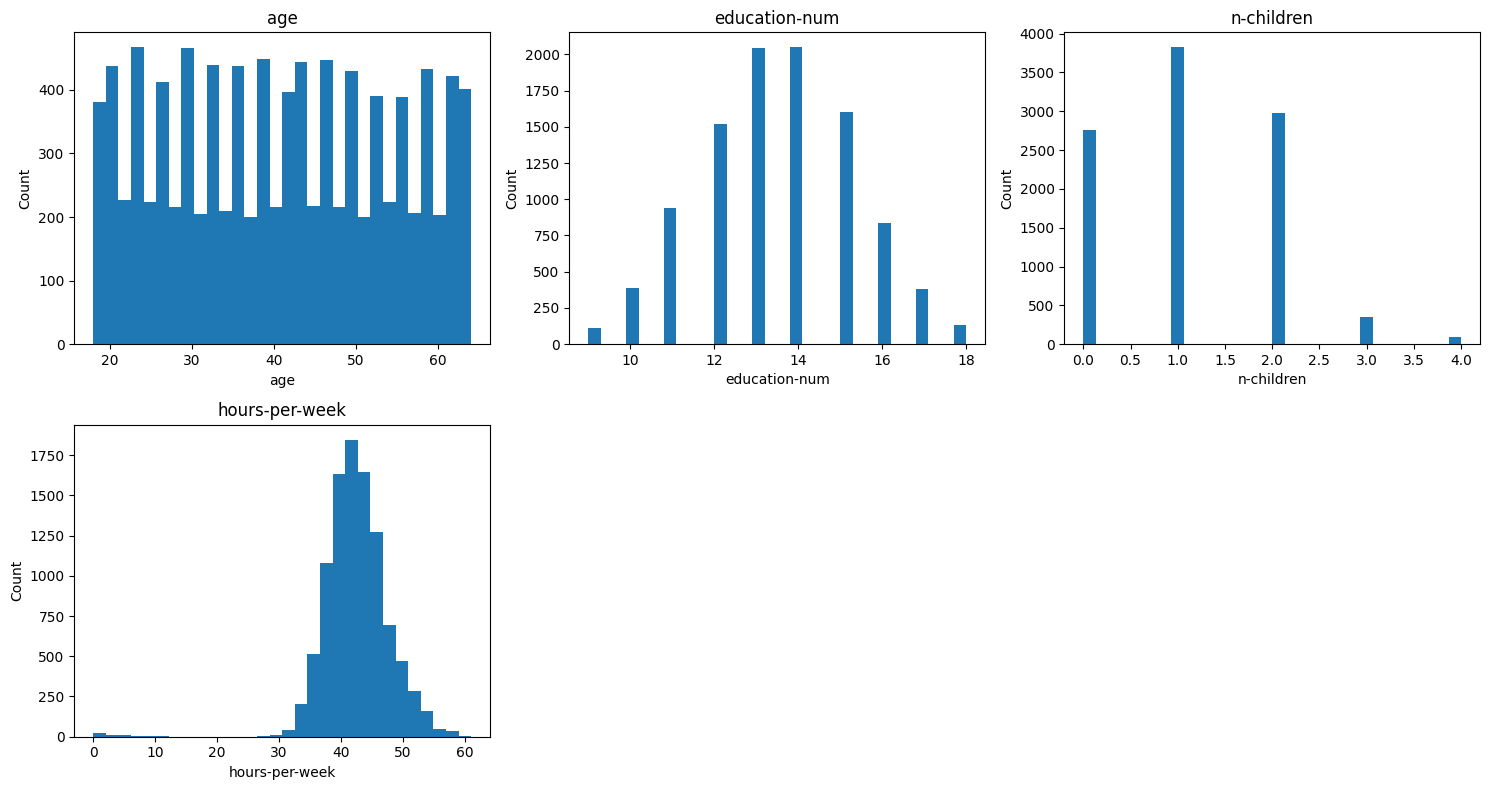

In [75]:
# Numeric variables to inspect
num_vars = ["age", "education-num", "n-children", "hours-per-week"]

n = len(num_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_vars):
    ax.hist(df_large_dataset_cat[col].dropna(), bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# Hide unused subplots
for i in range(len(num_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


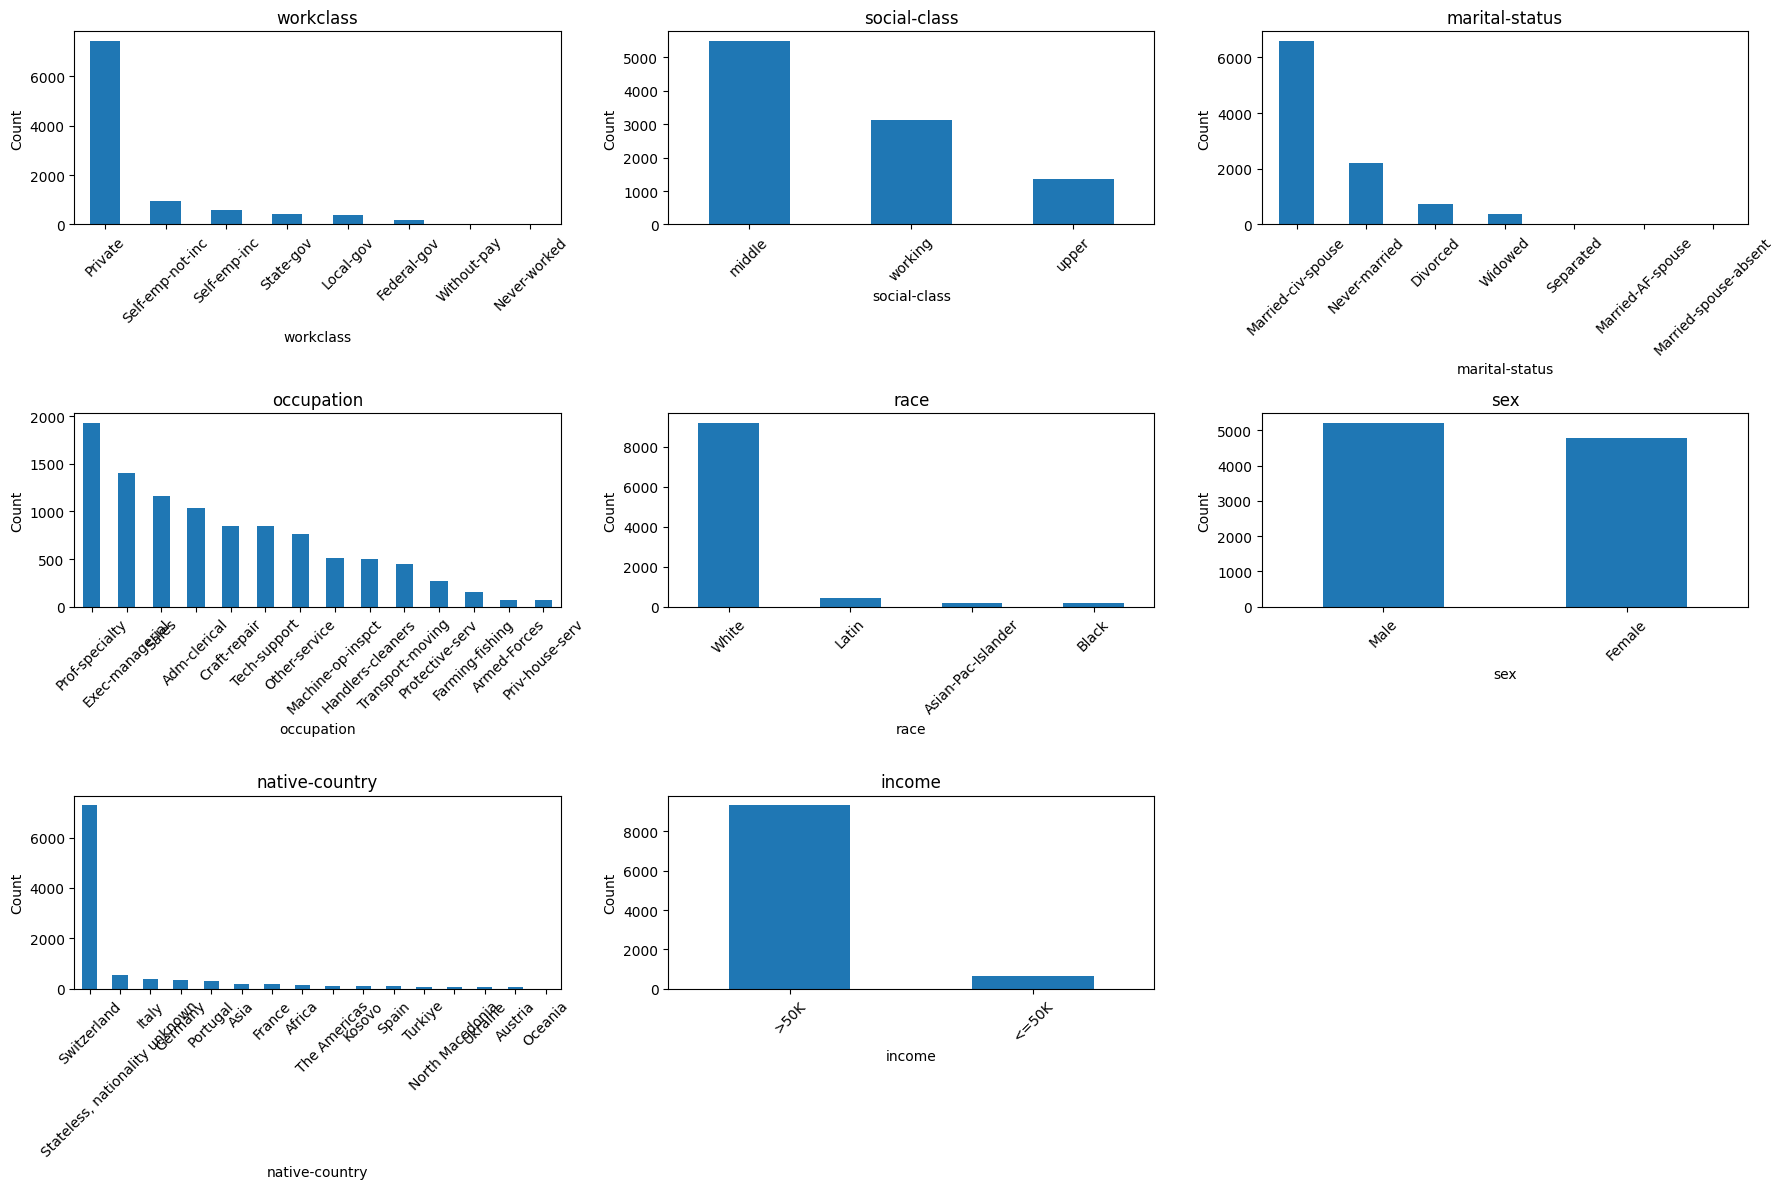

In [76]:
# Categorical variables to inspect
cat_vars = [
    "workclass",
    "social-class",
    "marital-status",
    "occupation",
    "race",
    "sex",
    "native-country",
    "income",
]

n = len(cat_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cat_vars):
    counts = df_large_dataset_cat[col].value_counts().sort_values(ascending=False)
    counts.plot(kind="bar", ax=ax)
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", labelrotation=45)

# Hide unused subplots
for i in range(len(cat_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


### Model Choice

In [77]:
results_df_simulation, artifacts = evaluate_income_classifiers(df_large_dataset_cat)
results_df_simulation

C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

,Model,Test_Accuracy,Test_F1,ROC_AUC,CV_Accuracy,Acc_CI_2.5,Acc_CI_97.5
0,KNN,0.942,0.969,0.838,0.943,0.967,0.973
1,Linear SVM,0.963,0.980,0.978,0.960,0.960,0.970
2,Naive Bayes,0.784,0.870,0.909,0.750,0.603,0.837
3,Random Forest,0.960,0.979,0.977,0.961,1.000,1.000
4,Decision Tree,0.956,0.976,0.817,0.950,1.000,1.000
5,Gradient Boosting,0.966,0.982,0.985,0.967,0.976,0.981
6,AdaBoost,0.947,0.972,0.976,0.946,0.943,0.951


#### Train model and Features importance

In [78]:
impurity_df, impurity_by_var, perm_by_var, art = gradient_boosting_feature_importance_report(
    df_large_dataset_cat,
    target_col="income",
    scoring="accuracy",
)

display(impurity_df.head(20))
display(impurity_by_var)
display(perm_by_var)


,Feature,Importance
0,hours-per-week,0.437864
1,occupation_Other-service,0.123699
2,occupation_Handlers-cleaners,0.114992
3,age,0.096476
4,occupation_Farming-fishing,0.067494
5,occupation_Priv-house-serv,0.039654
6,occupation_Prof-specialty,0.025926
7,education-num,0.023986
8,occupation_Exec-managerial,0.019143
9,sex_Male,0.018721


,Variable,Importance
0,hours-per-week,0.437864
1,occupation,0.404651
2,age,0.096476
3,education-num,0.023986
4,sex,0.018721
5,workclass,0.007213
6,social-class,0.005413
7,native-country,0.003263
8,marital-status,0.001666
9,race,0.000493


,Variable,Perm_Importance
0,hours-per-week,4.170000e-02
1,occupation,3.886667e-02
2,age,1.443333e-02
3,sex,4.766667e-03
4,education-num,4.066667e-03
5,social-class,3.666667e-04
6,marital-status,1.110223e-17
7,n-children,0.000000e+00
8,race,0.000000e+00
9,workclass,-2.000000e-04


## Main Pipeline

### Dataset importation

In [79]:
# Download latest version
path = kagglehub.dataset_download("uciml/adult-census-income")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\aurel\.cache\kagglehub\datasets\uciml\adult-census-income\versions\3


In [80]:
print(os.listdir(path))

['adult.csv']


In [81]:
file_path = os.path.join(path, "adult.csv")
df = pd.read_csv(file_path)

df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


#### Remove unuse columns

In [82]:
df = df.drop(columns=['education','fnlwgt'], axis=1)

df.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [83]:
# Replace "?" with NaN values
df.replace("?", np.nan, inplace = True)
df.head(5)

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


#### Replace undefined value

In [84]:
# Check for missing data
miss_data = df.isnull()
miss_data.sum()

age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [85]:
# Identify columns with missing data and their counts/percentages
miss_col = []
for column in miss_data.columns.values.tolist():
    if(miss_data[column].sum() > 0):
        print("Column: ",column)
        print("Missing Data: {} ({:.2f}%)".format(miss_data[column].sum(), (miss_data[column].sum() * 100/ len(df))))
        print("")
        miss_col.append(column)

Column:  workclass
Missing Data: 1836 (5.64%)

Column:  occupation
Missing Data: 1843 (5.66%)

Column:  native.country
Missing Data: 583 (1.79%)



In [86]:
def fill_with_conditional_mode(df, target_col, condition_cols):
    """
    Fill NaNs in `target_col` using the most frequent value among rows
    that share the same values in `condition_cols`.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe (modified in-place).
    target_col : str
        Column to impute (categorical).
    condition_cols : list[str]
        Columns used to define "similar" rows.

    Returns
    -------
    pd.DataFrame
        The same dataframe, for convenience.
    """
    # Global mode as final fallback
    global_mode = df[target_col].mode().iloc[0]

    missing_mask = df[target_col].isna()

    for idx, row in df[missing_mask].iterrows():
        # Start with all rows as candidates
        candidates_mask = pd.Series(True, index=df.index)

        # Keep only rows that match this row on all condition columns
        for c in condition_cols:
            val = row[c]
            if pd.notna(val):
                candidates_mask &= (df[c] == val)

        # Keep only rows where target_col is not missing
        candidates = df.loc[candidates_mask & df[target_col].notna(), target_col]

        if len(candidates) > 0:
            # Conditional mode
            df.at[idx, target_col] = candidates.mode().iloc[0]
        else:
            # Fallback: global mode of the column
            df.at[idx, target_col] = global_mode

    return df

In [87]:
# Impute 'workclass' based on occupation + socio-demographic profile
df = fill_with_conditional_mode(
    df,
    target_col="workclass",
    condition_cols=[
        "education.num", "marital.status",
        "occupation", "relationship", "race", "sex", "income"
    ],
)

# Impute 'occupation' based on workclass + socio-demographic profile
df = fill_with_conditional_mode(
    df,
    target_col="occupation",
    condition_cols=[
        "education.num", "marital.status",
        "workclass", "relationship", "race", "sex", "income"
    ],
)

# Impute 'native.country' based on race, sex, income, education.num, marital.status
df = fill_with_conditional_mode(
    df,
    target_col="native.country",
    condition_cols=[
        "race", "sex", "income", "education.num", "marital.status"
    ],
)


In [88]:
miss_data = df.isnull()
miss_data.sum()

age               0
workclass         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

### Outliers

#### Visulalisation

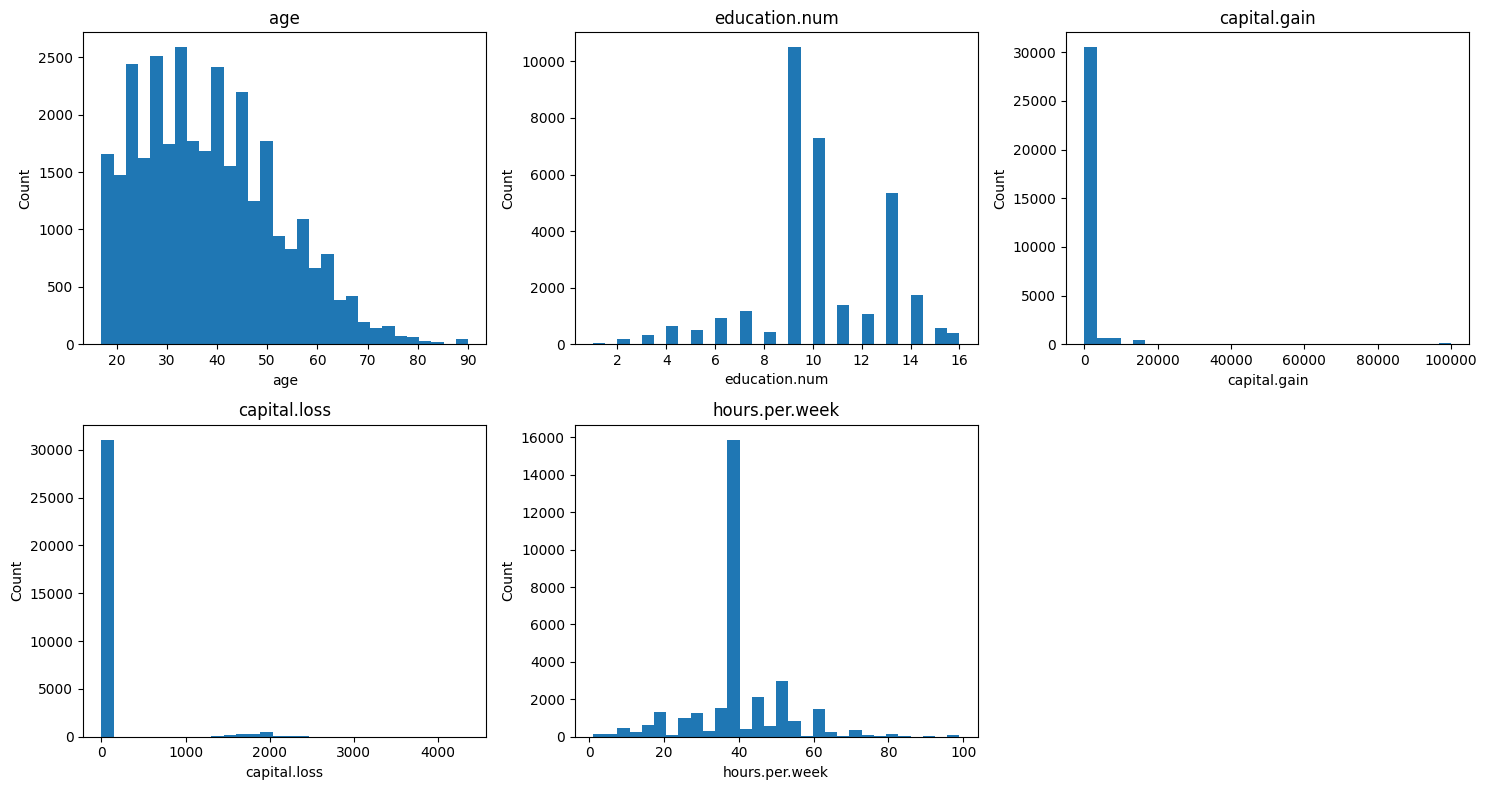

In [89]:
# Numeric variables to inspect
num_vars = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]

n = len(num_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_vars):
    ax.hist(df[col].dropna(), bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# Hide unused subplots
for i in range(len(num_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


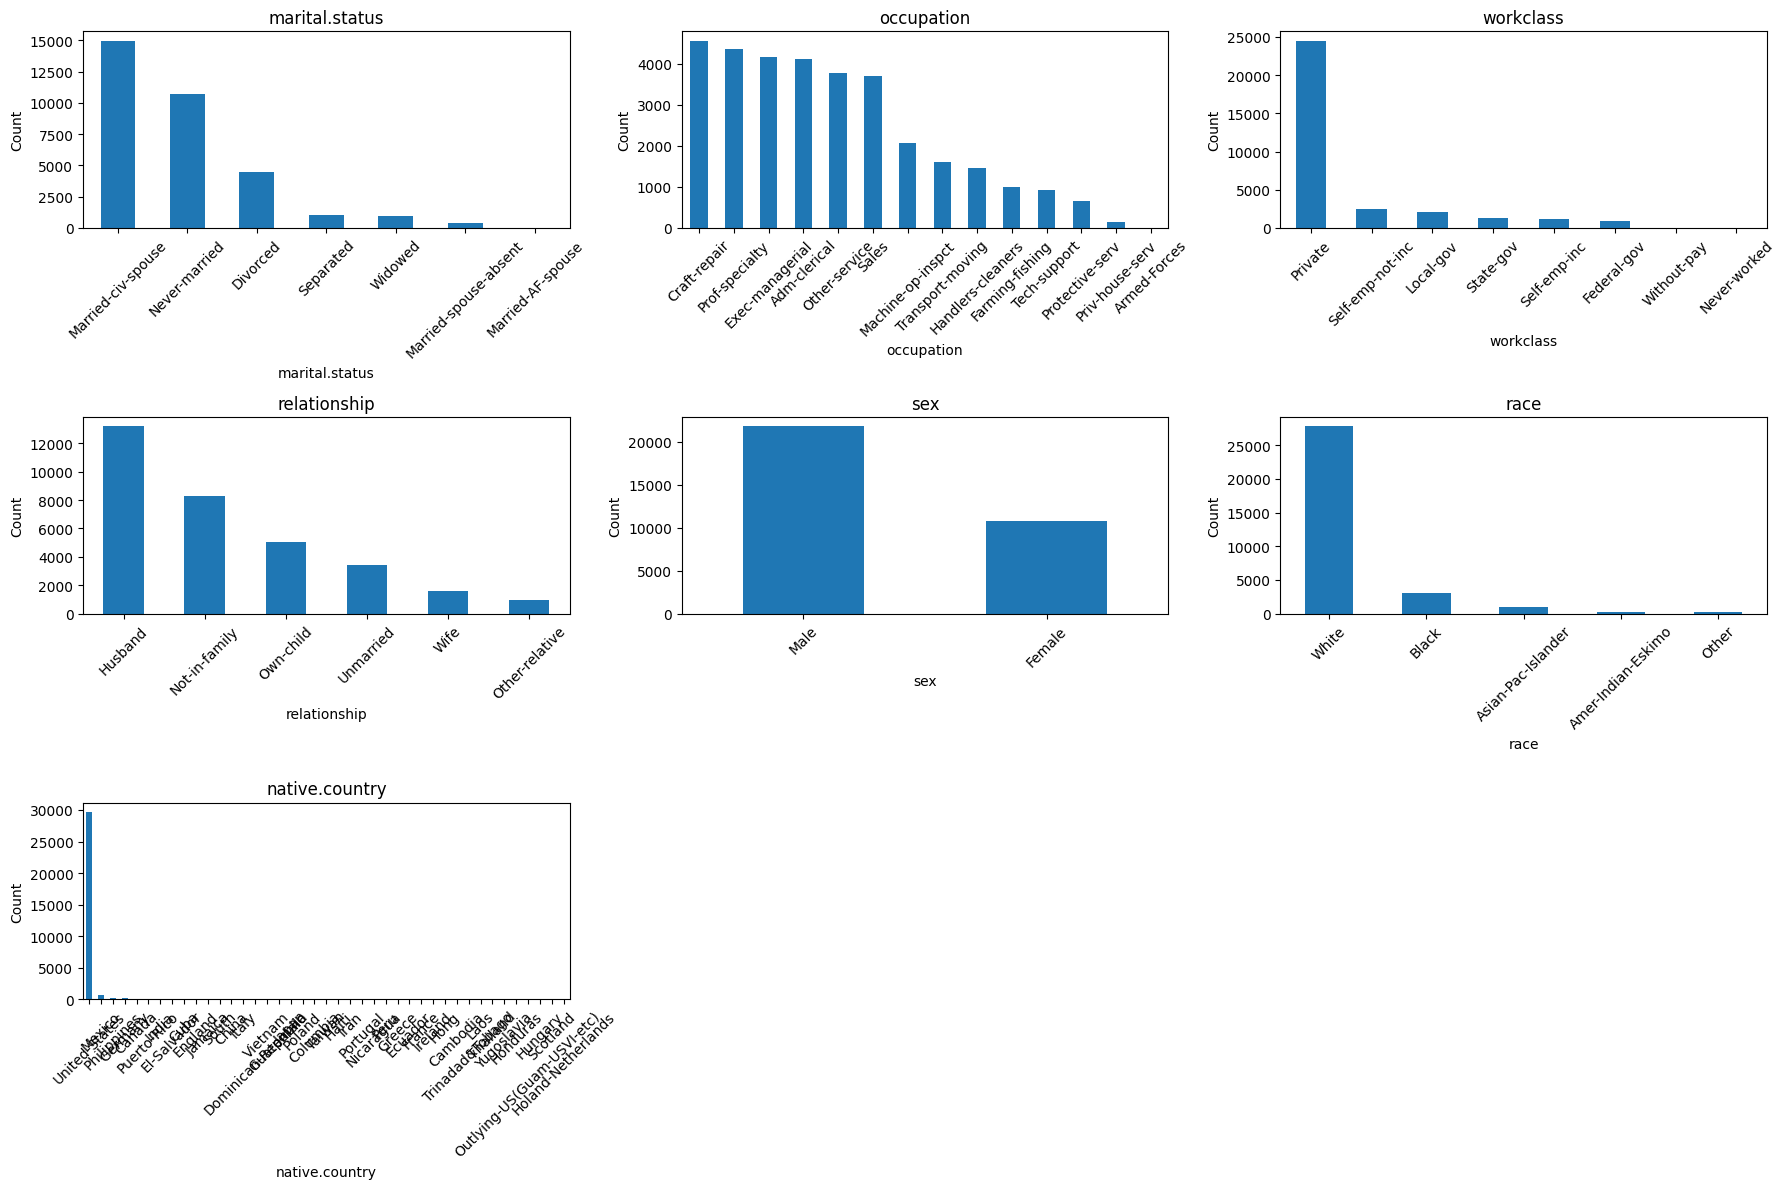

In [90]:
# Categorical variables to inspect
cat_vars = [
    "marital.status",
    "occupation",
    "workclass",
    "relationship",
    "sex",
    "race",
    "native.country",
]

n = len(cat_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cat_vars):
    counts = df[col].value_counts().sort_values(ascending=False)
    counts.plot(kind="bar", ax=ax)
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", labelrotation=45)

# Hide unused subplots
for i in range(len(cat_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


#### Detection

In [91]:
num_subset = df.select_dtypes(include=['int64', 'float64'])
print(num_subset.describe())

                age  education.num  capital.gain  capital.loss  hours.per.week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679   1077.648844     87.303830       40.437456
std       13.640433       2.572720   7385.292085    402.960219       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000


In [92]:
# Detect outliers using IQR method
num_subset = df.select_dtypes(include=["int64", "float64"])

for col in num_subset.columns:
    q1, q3 = num_subset[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0:
        print(f"{col}: IQR = 0, méthode IQR non adaptée (beaucoup de zéros ?)")
        continue

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_low  = (num_subset[col] < lower).sum()
    n_high = (num_subset[col] > upper).sum()
    print(f"{col}: [{lower:.2f}, {upper:.2f}] → {n_low} low, {n_high} high")


age: [-2.00, 78.00] → 0 low, 143 high
education.num: [4.50, 16.50] → 1198 low, 0 high
capital.gain: IQR = 0, méthode IQR non adaptée (beaucoup de zéros ?)
capital.loss: IQR = 0, méthode IQR non adaptée (beaucoup de zéros ?)
hours.per.week: [32.50, 52.50] → 5516 low, 3492 high


## Model Choice

In [93]:
results_df, artifacts = evaluate_income_classifiers(df)
results_df

C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

,Model,Test_Accuracy,Test_F1,ROC_AUC,CV_Accuracy,Acc_CI_2.5,Acc_CI_97.5
0,KNN,0.840,0.666,0.869,0.780,0.918,0.923
1,Linear SVM,0.852,0.660,0.900,0.821,0.846,0.854
2,Naive Bayes,0.820,0.670,0.886,0.810,0.815,0.828
3,Random Forest,0.846,0.658,0.894,0.800,0.984,0.986
4,Decision Tree,0.823,0.624,0.769,0.766,0.984,0.986
5,Gradient Boosting,0.861,0.675,0.916,0.810,0.868,0.876
6,AdaBoost,0.851,0.631,0.902,0.807,0.853,0.857


### Train model and Features importance

In [94]:
impurity_df, impurity_by_var, perm_by_var, art = gradient_boosting_feature_importance_report(
    df,
    target_col="income",
    scoring="accuracy",
)

display(impurity_df.head(20))
display(impurity_by_var)
display(perm_by_var)


,Feature,Importance
0,marital.status_Married-civ-spouse,0.383033
1,education.num,0.198727
2,capital.gain,0.197803
3,age,0.064329
4,capital.loss,0.060901
5,hours.per.week,0.038179
6,occupation_Exec-managerial,0.017888
7,occupation_Prof-specialty,0.007210
8,occupation_Other-service,0.006052
9,occupation_Farming-fishing,0.005414


,Variable,Importance
0,marital.status,0.383938
1,education.num,0.198727
2,capital.gain,0.197803
3,age,0.064329
4,capital.loss,0.060901
5,occupation,0.041437
6,hours.per.week,0.038179
7,relationship,0.006697
8,workclass,0.003846
9,sex,0.002040


,Variable,Perm_Importance
0,marital.status,0.043525
1,capital.gain,0.042543
2,education.num,0.031068
3,age,0.015938
4,capital.loss,0.011844
5,occupation,0.007688
6,hours.per.week,0.006930
7,relationship,0.002037
8,workclass,0.001587
9,sex,0.000512


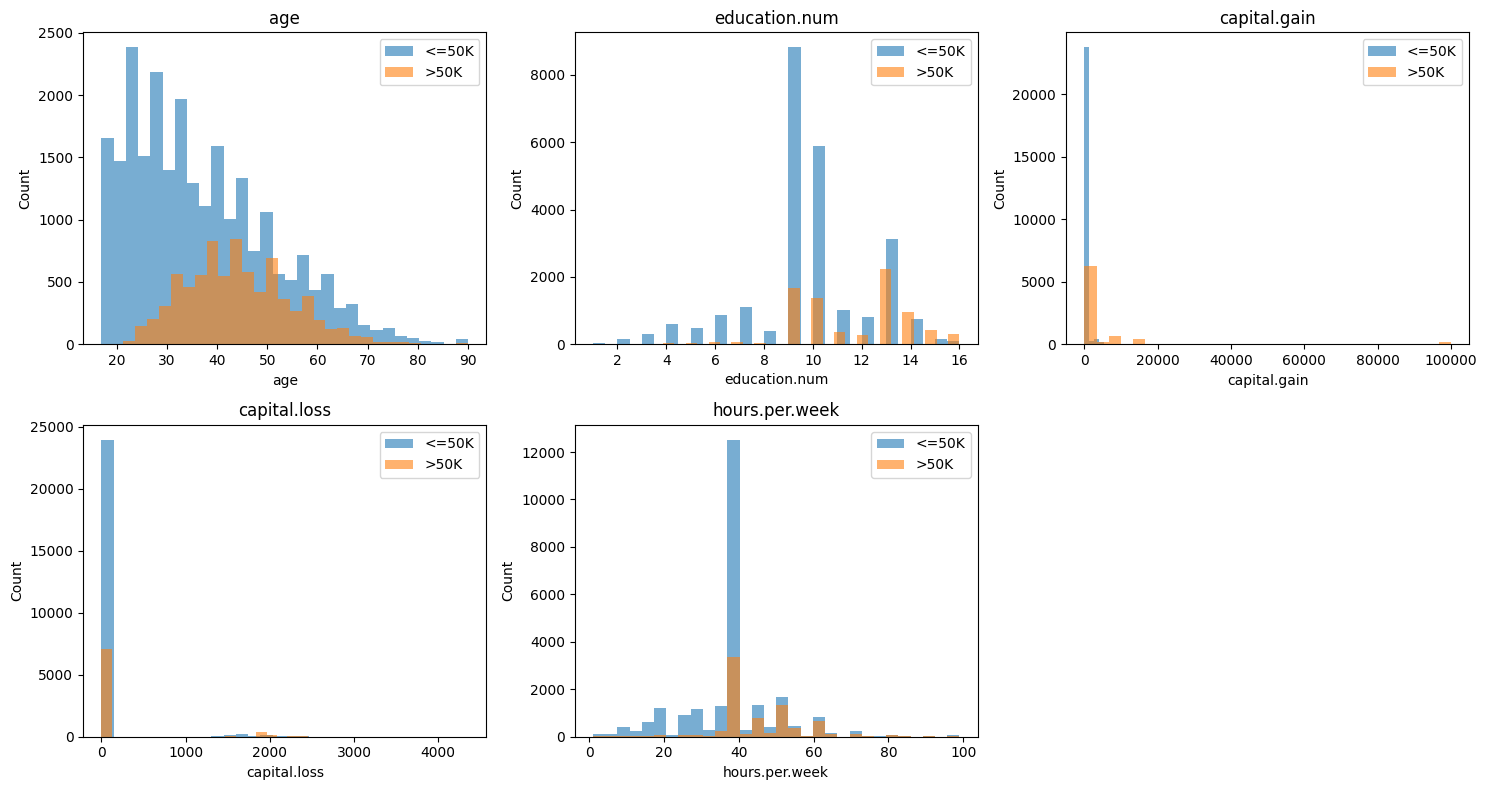

In [95]:
# Clean income labels just in case there are spaces
income_clean = df["income"].astype(str).str.strip()
mask_high = income_clean == ">50K"
mask_low = income_clean == "<=50K"

num_vars = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]

n = len(num_vars)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_vars):
    # Low income
    ax.hist(df.loc[mask_low, col].dropna(), bins=30, alpha=0.6, label="<=50K")
    # High income
    ax.hist(df.loc[mask_high, col].dropna(), bins=30, alpha=0.6, label=">50K")
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend()

for i in range(len(num_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [96]:
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """
    Compute Cramér's V for two categorical variables.
    
    Parameters
    ----------
    x : pd.Series
        First categorical variable.
    y : pd.Series
        Second categorical variable.
    
    Returns
    -------
    float
        Association in [0, 1].
    """
    table = pd.crosstab(x, y)
    if table.size == 0:
        return np.nan
    
    chi2, p, dof, expected = chi2_contingency(table)
    n = table.values.sum()
    if n == 0:
        return np.nan
    
    r, k = table.shape
    if min(r, k) <= 1:
        return 0.0
    
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


def correlation_ratio(categories: pd.Series, values: pd.Series) -> float:
    """
    Compute correlation ratio (eta) for a categorical and a numerical variable.
    
    Parameters
    ----------
    categories : pd.Series
        Categorical variable.
    values : pd.Series
        Numerical variable.
    
    Returns
    -------
    float
        Correlation ratio in [0, 1].
    """
    # Drop missing
    mask = (~pd.isna(categories)) & (~pd.isna(values))
    cat = pd.Categorical(categories[mask])
    y = values[mask].astype(float).values
    
    if y.size == 0:
        return np.nan
    
    overall_mean = y.mean()
    ss_between = 0.0
    ss_total = ((y - overall_mean) ** 2).sum()
    
    for level in np.unique(cat):
        level_mask = (cat == level)
        y_level = y[level_mask]
        if y_level.size == 0:
            continue
        ss_between += y_level.size * (y_level.mean() - overall_mean) ** 2
    
    if ss_total == 0:
        return 0.0
    
    eta_squared = ss_between / ss_total
    eta = np.sqrt(eta_squared)
    return float(eta)


In [97]:
def mixed_assoc_matrix(df: pd.DataFrame, cols=None) -> pd.DataFrame:
    """
    Compute a mixed-type association matrix for the given columns.
    
    - numeric-numeric: Pearson correlation ([-1, 1])
    - cat-cat: Cramér's V ([0, 1])
    - numeric-cat: correlation ratio eta ([0, 1])
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    cols : list of str, optional
        Columns to include. If None, all columns are used.
    
    Returns
    -------
    pd.DataFrame
        Square matrix of associations.
    """
    if cols is None:
        cols = list(df.columns)
    else:
        cols = list(cols)
    
    assoc = pd.DataFrame(np.nan, index=cols, columns=cols)
    
    numeric_cols = df[cols].select_dtypes(include="number").columns.tolist()
    cat_cols = [c for c in cols if c not in numeric_cols]
    
    for i, col_i in enumerate(cols):
        for j, col_j in enumerate(cols):
            if j < i:
                continue  # already computed (symmetry)
            
            s_i = df[col_i]
            s_j = df[col_j]
            mask = (~s_i.isna()) & (~s_j.isna())
            s_i2 = s_i[mask]
            s_j2 = s_j[mask]
            
            if s_i2.empty:
                value = np.nan
            elif (col_i in numeric_cols) and (col_j in numeric_cols):
                # numeric-numeric
                value = s_i2.astype(float).corr(s_j2.astype(float))
            elif (col_i in cat_cols) and (col_j in cat_cols):
                # cat-cat
                value = cramers_v(s_i2, s_j2)
            else:
                # mixed: numeric-cat
                if col_i in numeric_cols:
                    num = s_i2
                    cat = s_j2
                else:
                    num = s_j2
                    cat = s_i2
                value = correlation_ratio(cat, num)
            
            assoc.loc[col_i, col_j] = value
            assoc.loc[col_j, col_i] = value
    
    return assoc


In [98]:
cols = [
    "age", "workclass", "education.num", "marital.status",
    "occupation", "relationship", "race", "sex",
    "capital.gain", "capital.loss", "hours.per.week",
    "native.country", "income"
]

assoc = mixed_assoc_matrix(df, cols=cols)

print("Mixed-type association matrix:")
print(assoc.round(3))


Mixed-type association matrix:
                  age  workclass  education.num  marital.status  occupation  \
age             1.000      0.208          0.037           0.574       0.218   
workclass       0.208      1.000          0.190           0.078       0.199   
education.num   0.037      0.190          1.000           0.115       0.568   
marital.status  0.574      0.078          0.115           1.000       0.140   
occupation      0.218      0.199          0.568           0.140       1.000   
relationship    0.474      0.091          0.161           0.488       0.192   
race            0.044      0.055          0.110           0.084       0.084   
sex             0.089      0.143          0.012           0.462       0.452   
capital.gain    0.078      0.104          0.123           0.087       0.119   
capital.loss    0.058      0.046          0.080           0.082       0.084   
hours.per.week  0.069      0.168          0.148           0.251       0.274   
native.country  0.087

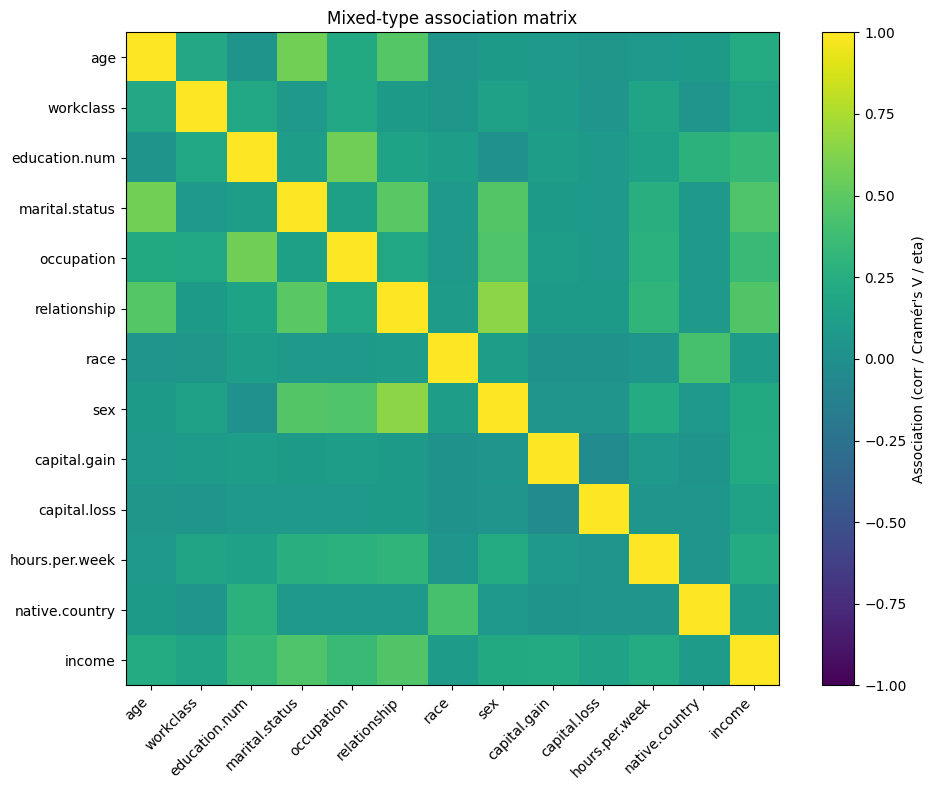

In [99]:

plt.figure(figsize=(10, 8))
im = plt.imshow(assoc, vmin=-1, vmax=1)
plt.colorbar(im, label="Association (corr / Cramér's V / eta)")

plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title("Mixed-type association matrix")
plt.tight_layout()
plt.show()


In [100]:
levels = {
    "native.country": 0,
    "race": 0,
    "sex": 0,
    "age": 1,
    "education.num": 2,
    "workclass": 3,
    "marital.status": 3,
    "occupation": 4,
    "relationship": 5,
    "hours.per.week": 6,
    "capital.gain": 6,
    "capital.loss": 6,
    "income": 7,
}


In [101]:
threshold = 0.1  # on garde >0.5 ou <-0.5

strong_edges = []

for i, col_i in enumerate(cols):
    for j in range(i + 1, len(cols)):
        col_j = cols[j]
        val = assoc.loc[col_i, col_j]
        if pd.notna(val) and abs(val) >= threshold:
            # Orienter selon l'ordre "causal"
            li = levels[col_i]
            lj = levels[col_j]
            if li < lj:
                strong_edges.append((col_i, col_j, val))
            elif lj < li:
                strong_edges.append((col_j, col_i, val))
            else:
                # même niveau -> soit on ignore, soit on décide à la main
                # ici on ignore pour garder un DAG propre
                pass

print("Arêtes fortes du DAG (source -> cible, association):")
for u, v, w in sorted(strong_edges, key=lambda t: abs(t[2]), reverse=True):
    print(f"{u:15s} -> {v:15s}  (assoc = {w:.3f})")


Arêtes fortes du DAG (source -> cible, association):
sex             -> relationship     (assoc = 0.649)
age             -> marital.status   (assoc = 0.574)
education.num   -> occupation       (assoc = 0.568)
marital.status  -> relationship     (assoc = 0.488)
age             -> relationship     (assoc = 0.474)
sex             -> marital.status   (assoc = 0.462)
relationship    -> income           (assoc = 0.454)
sex             -> occupation       (assoc = 0.452)
marital.status  -> income           (assoc = 0.447)
occupation      -> income           (assoc = 0.354)
education.num   -> income           (assoc = 0.335)
relationship    -> hours.per.week   (assoc = 0.310)
native.country  -> education.num    (assoc = 0.283)
occupation      -> hours.per.week   (assoc = 0.274)
marital.status  -> hours.per.week   (assoc = 0.251)
age             -> income           (assoc = 0.234)
hours.per.week  -> income           (assoc = 0.230)
sex             -> hours.per.week   (assoc = 0.229)
capital.gai

C:\Users\aurel\AppData\Local\Temp\ipykernel_36464\1120599581.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


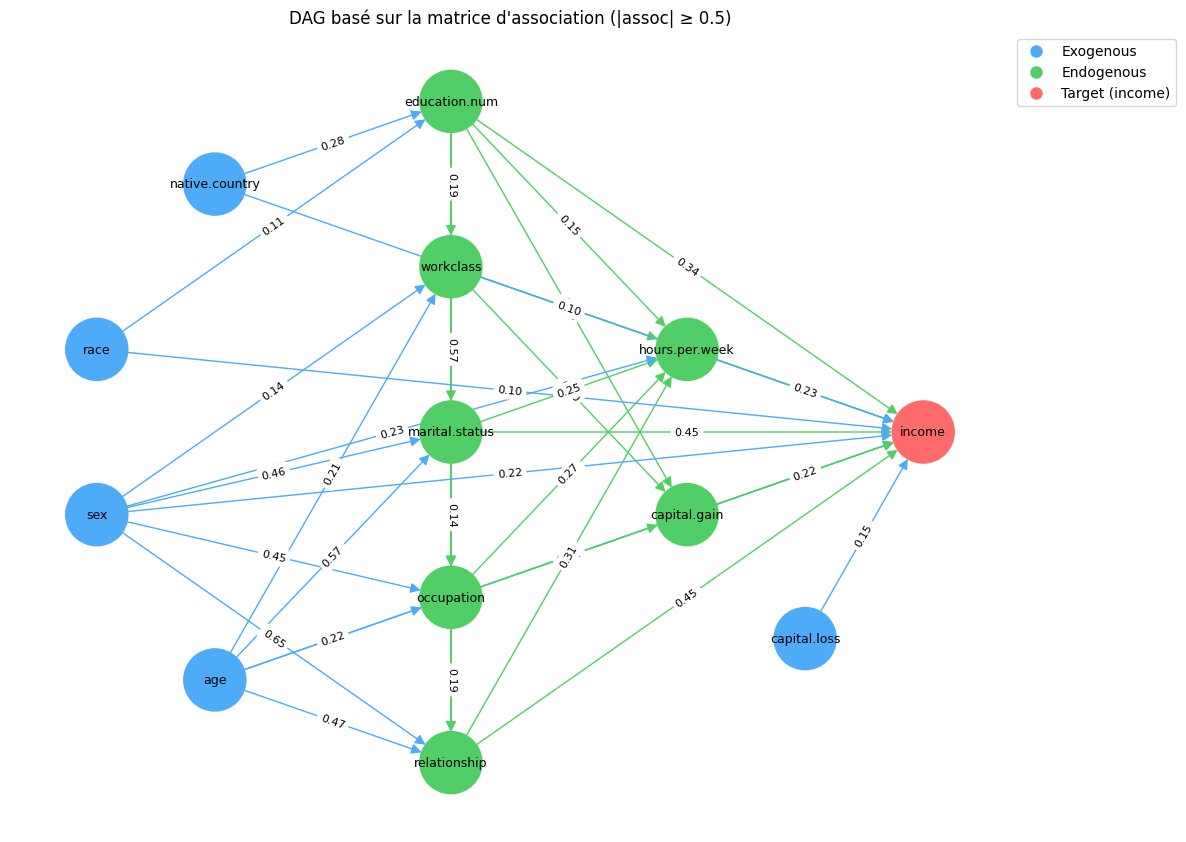

In [102]:
# === 1. Build the graph as before ==========================================
G = nx.DiGraph()
G.add_nodes_from(cols)
for u, v, w in strong_edges:
    G.add_edge(u, v, weight=w)

# === 2. Positions (your manual layout) =====================================
pos = {
     "native.country": (-4,  3),
     "race":           (-4.5,  2),
     "sex":            ( -4.5,  1),
     "age":            ( -4,  0),
     "education.num":  (-3,  3.5),
     "workclass":      (-3,  2.5),
     "marital.status": ( -3,  1.5),
     "occupation":     ( -3,  0.5),
     "relationship":   ( -3,  -0.5),
     "hours.per.week": (-2, 2),
     "capital.gain":   ( -2, 1),
     "capital.loss":   ( -1.5, 0.25),
     "income":         (-1, 1.5),
 }

# === 3. Classify nodes: exogenous / endogenous / target ====================
target_var = "income"

exogenous_nodes = [n for n in G.nodes if G.in_degree(n) == 0 and n != target_var]

endogenous_nodes = [
    n for n in G.nodes
    if n not in exogenous_nodes and n != target_var
]

# Build node colors (same as before)
node_colors = []
for n in G.nodes:
    if n == target_var:
        node_colors.append("#ff6b6b")   # target = red-ish
    elif n in exogenous_nodes:
        node_colors.append("#4dabf7")   # exogenous = blue-ish
    else:
        node_colors.append("#51cf66")   # endogenous = green-ish

# === NEW: Build edge colors based on the SOURCE node =======================
edges = list(G.edges())   # fixed order for edges

edge_colors = []
for u, v in edges:
    if u == target_var:
        edge_colors.append("#ff6b6b")   # edge coming from target
    elif u in exogenous_nodes:
        edge_colors.append("#4dabf7")   # edge coming from exogenous
    else:
        edge_colors.append("#51cf66")   # edge coming from endogenous

# === 4. Draw the DAG =======================================================
plt.figure(figsize=(10, 8))

nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=2000,
    font_size=9,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=15,
    edgelist=edges,           # make sure edge order matches edge_colors
    edge_color=edge_colors,   # <- colored by source variable
)

# Edge labels (weights)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Legend for node types
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor="#4dabf7", markersize=10, label="Exogenous"),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor="#51cf66", markersize=10, label="Endogenous"),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor="#ff6b6b", markersize=10, label="Target (income)"),
]
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))

plt.title("DAG basé sur la matrice d'association (|assoc| ≥ 0.5)")
plt.axis("off")
plt.tight_layout()
plt.show()
